# MODEL 3 - Custom ConvNet

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.python.data import AUTOTUNE
from tensorflow.keras import layers as kl
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks as cb
import tensorflow_addons as tfa


if os.getcwd().startswith("/Users"): os.chdir(os.getcwd().split("/notebooks", 1)[0])

from src.config.notebook_config import NotebookConfig
from src.evaluation.evaluation import Evaluation

from src.data.utility.tf_dataset_transformer import TfDatasetTransformer

%load_ext autoreload
%autoreload 2

# Config

In [2]:
MODEL_NAME = "model_3"

import src.data.dataset.dataset_v3_loader as dataset_loader # V3
DATASET_LOADER = dataset_loader

config = NotebookConfig(MODEL_NAME, dataset_loader.dataset_name())

BATCH_SIZE = 64

# Data Loading

In [3]:
train_dataset = DATASET_LOADER.load_train_v3()
val_dataset = DATASET_LOADER.load_validation_v3()

In [4]:
pair_tuples = list(map(lambda pair: (pair.image_a, pair.image_b, pair.similar), train_dataset.image_pairs))
pair_array = np.array(pair_tuples)


tf_dataset_transformer =  TfDatasetTransformer(image_shape=config.image_shape)

train_tf_dataset = tf_dataset_transformer.transform_to_tf_dataset(train_dataset, shuffle=True, shuffle_buffer_size=1024)\
                                         .cache("./tf_cache/train_dataset")\
                                         .batch(BATCH_SIZE)\
                                         .prefetch(AUTOTUNE)

val_tf_dataset = tf_dataset_transformer.transform_to_tf_dataset(val_dataset)\
                                         .cache("./tf_cache/val_dataset")\
                                         .batch(128)\
                                         .prefetch(AUTOTUNE)

2022-03-28 19:44:10.167728: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model

In [35]:
def create_common_model() -> keras.Model:
    input = keras.Input(shape=config.image_shape.to_shape())
    x = kl.Conv2D(filters=64, kernel_size=7, strides=2, activation="relu", padding="valid")(input)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(0.2)(x)
    x = kl.MaxPool2D(pool_size=3)(x)
    x = kl.Conv2D(filters=96, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(0.2)(x)
    x = kl.MaxPool2D(pool_size=3)(x)
    x = kl.Flatten()(x)
    return keras.Model(inputs=input, outputs=x)

def create_model() -> keras.Model:
    input_a = keras.Input(shape=config.image_shape.to_shape())
    input_b = keras.Input(shape=config.image_shape.to_shape())

    common_model = create_common_model()

    layer_a = common_model(input_a)
    layer_b = common_model(input_b)

    merge_layer = tf.abs(tf.subtract(layer_a, layer_b))
    merge_layer = kl.Dropout(0.2)(merge_layer)
    merge_layer = kl.Dense(1, activation="sigmoid")(merge_layer)

    return keras.Model(inputs=[input_a, input_b], outputs=merge_layer, name=MODEL_NAME)

metric_f1 = tfa.metrics.f_scores.F1Score(num_classes=1, average="micro", name="f1-micro")
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=727, decay_rate=0.75)

model = create_model()
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule), loss=losses.CategoricalHinge(), metrics=["accuracy", metric_f1])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           (None, 9600)         163808      ['input_16[0][0]',               
                                                                  'input_17[0][0]']         

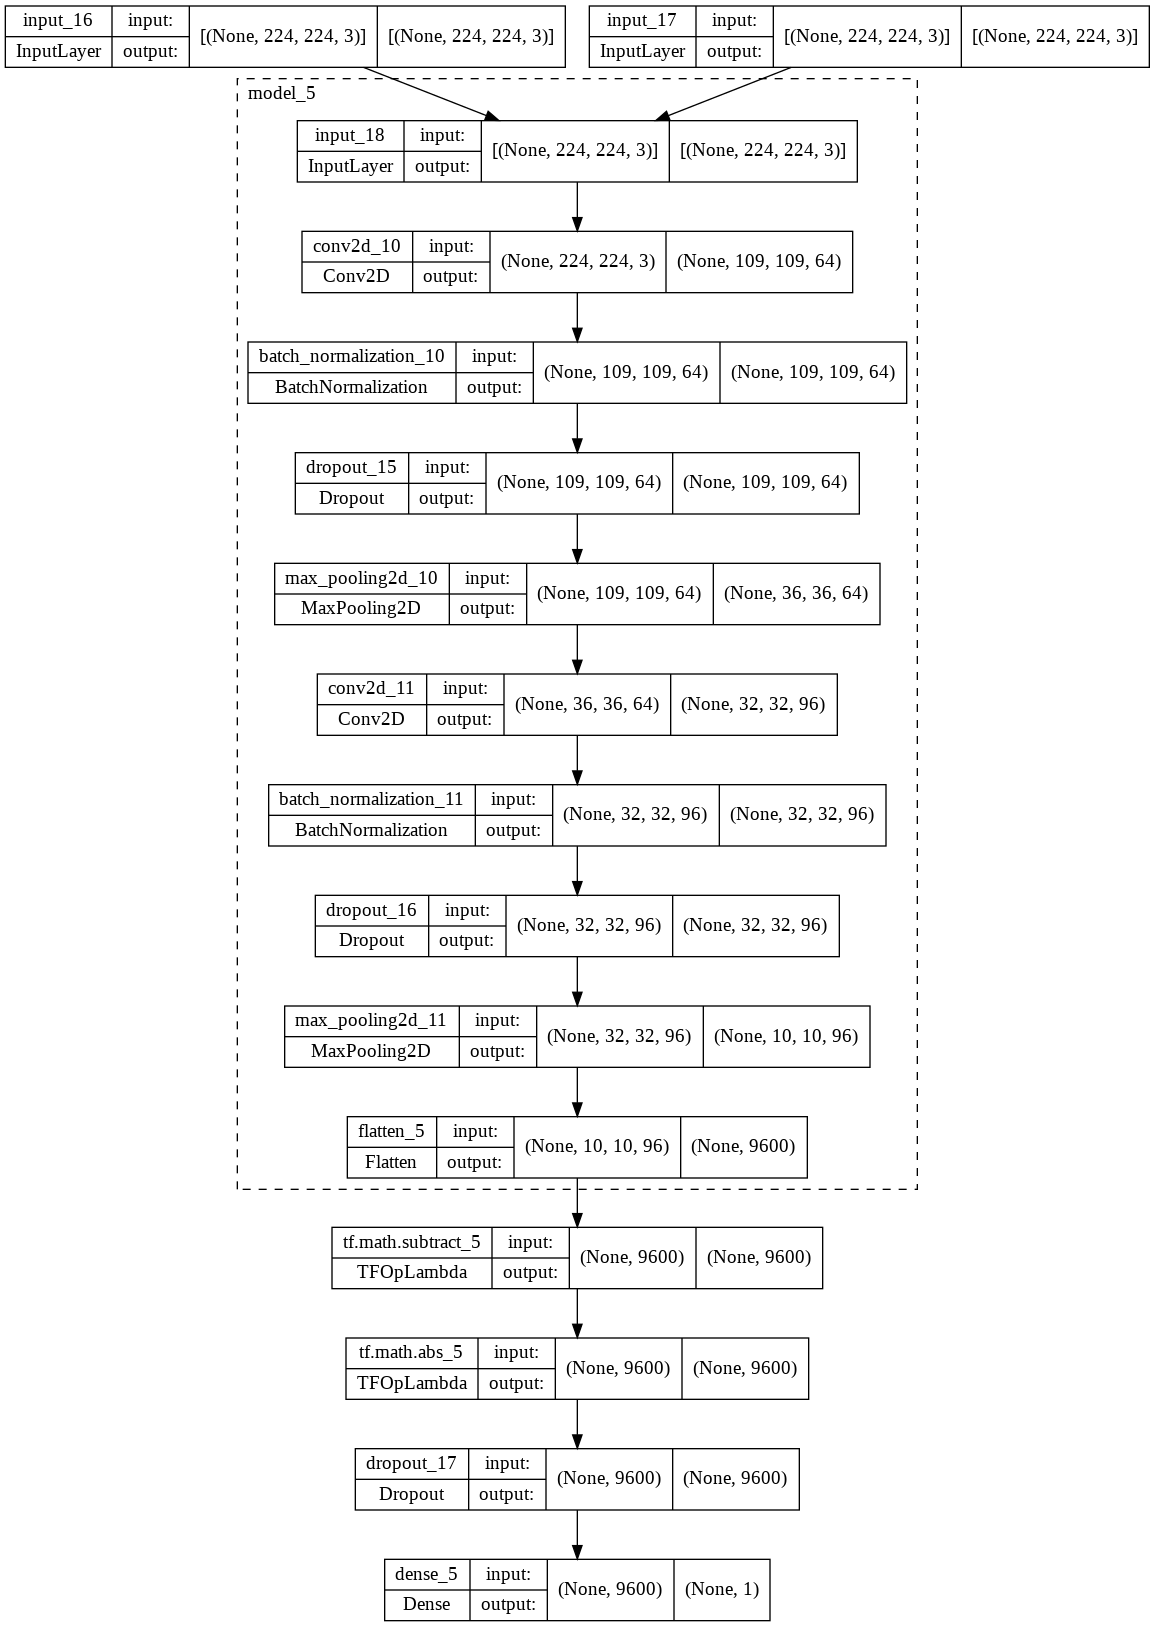

In [36]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
save_cb = cb.ModelCheckpoint(config.model_output_path, save_best_only=True)
tensorboard_cb = cb.TensorBoard(log_dir=config.tensorboard_log_dir)

history = model.fit(train_tf_dataset, epochs=20, workers=8, max_queue_size=20, validation_data=val_tf_dataset, callbacks=[save_cb, tensorboard_cb])

pd.DataFrame(history.history).plot()

In [ ]:
import gc
gc.collect(2)#%%

33302

# Evaluation

In [5]:
model: keras.Model = keras.models.load_model(config.saved_model_path)

In [6]:
evaluation = Evaluation(dataset=val_dataset, image_shape=config.image_shape, model=model)

In [ ]:
evaluation.print_f1_report(threshold=0.5)
evaluation.print_separate_f1_reports(threshold=0.5)
evaluation.plot_roc()

In [ ]:
evaluation.show_images(range(8000, 8100))